<a href="https://colab.research.google.com/github/vic-torr/thesis-experiments/blob/main/experiments/rsp_swin_t_13_11_22_swin_14_epoch_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config

In [1]:
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 4
if RunningInCOLAB:
    BATCH_SIZE = 48
FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 10
GAMMA = 0.9
N_EPOCHS = 5
VERSION = 'release'
PRETRAIN_WEIGHTS = 'IMAGENET1K_V1'
PRETRAIN_WEIGHTS = 'rsp-swin-t-ckpt.pth'
config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": PRETRAIN_WEIGHTS}
CHECKPOINT_ENABLED = False          

# Set Environment

In [2]:
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/drive/MyDrive/Colab-Notebooks/datasets/planet
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    checkpoint_path = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/content/planet/"
    #dataset_dir="/content/drive/MyDrive/Colab-Notebooks/datasets/planet/"
else:
    home = os.environ['HOME']
    dataset_dir = home+"/UFMG/Thesis/datasets/planet"
    checkpoint_path = home+'/UFMG/Thesis/Experiments/checkpoints/'

In [3]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn pytorch-ignite dill tqdm plotly matplotlib torchinfo virtualenv opencv-python datasets evaluate timm yacs

In [4]:
import timm
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.optim import AdamW, Adam
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.optim as optim
from torch import nn, Tensor
from torchvision import transforms
import torch
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import cv2

import pandas as pd
import numpy as np  # Torch wrapper for Numpy
from PIL import Image
import os
import gc
import random
import threading
from copy import copy, deepcopy
from time import time
from glob import glob
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [5]:
if not CHECKPOINT_ENABLED:
    try:
        os.remove(checkpoint_path+f"train_results_{VERSION}.pkl")
        os.remove(checkpoint_path+f"swin_t_{VERSION}.pth")
        print("clear")  
    except:
        pass

In [6]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1001)

# EDA

In [7]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


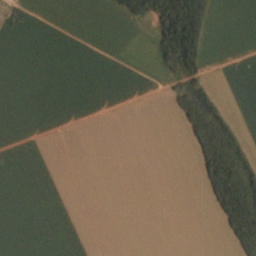

In [8]:
image_file = Image.open(path_train+'/train_32.jpg').convert("RGB")
display(image_file)

In [9]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [10]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

#fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
#fig.update_layout(title="Class distribution")
# fig.show()


In [11]:
classes = df_tags["total"].sum()

In [12]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [13]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(
        f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(
        f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1431% (694)
val bare_ground: 2.0751% (168)

train selective_logging: 0.8399% (272)
val selective_logging: 0.8399% (68)

train artisinal_mine: 0.8152% (264)
val artisinal_mine: 0.9264% (75)

train blooming: 0.8461% (274)
val blooming: 0.7164% (58)

train slash_burn: 0.5373% (174)
val slash_burn: 0.4323% (35)

train blow_down: 0.2501% (81)
val blow_down: 0.2100% (17)

train conventional_mine: 0.2378% (77)
val conventional_mine: 0.2841% (23)



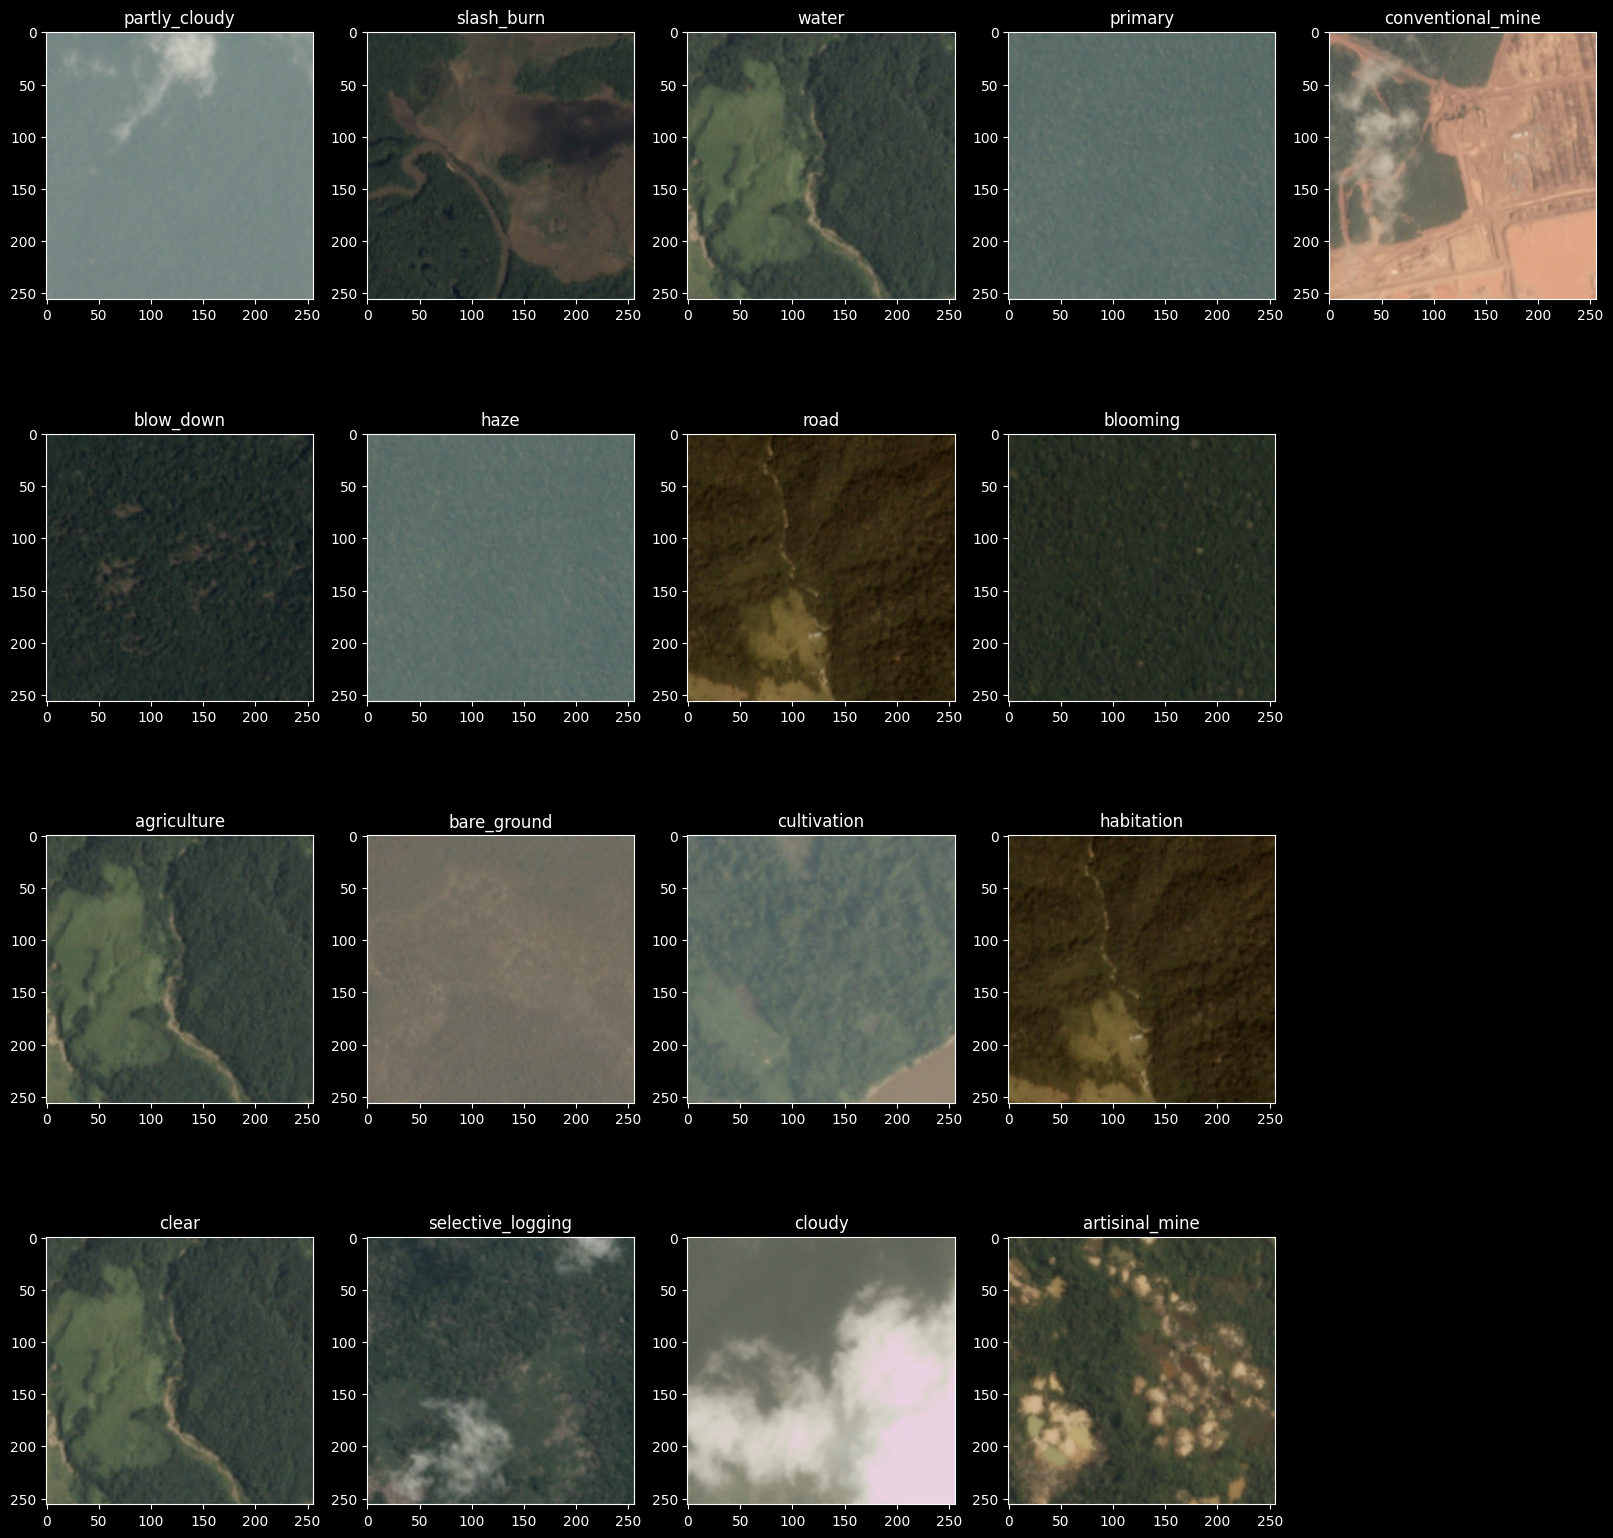

In [14]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(
        tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [15]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [16]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [17]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

In [18]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=2,
    )
    X_embedded = tsne.fit_transform(X_train_sample)
    X_embedded.shape

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / \
        (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 *
                       offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img_tsne)
    plt.axis("off")
# tsne_analysis()


# Dataset prep

In [19]:
# create image augmentations
transform_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ]
)

In [20]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(
                f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(
                f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [21]:
#from multiprocessing import set_start_method
#multiprocessing_context = torch.multiprocessing.set_start_method('spawn')

def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(
        encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        # persistent_workers=True,
        #multiprocessing_context = multiprocessing_context
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        # persistent_workers=True,
        #multiprocessing_context = multiprocessing_context
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train


In [22]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)

def untest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

untest_loader()

torch.Size([4, 3, 224, 224]) torch.Size([4, 17])
torch.Size([4, 3, 224, 224]) torch.Size([4, 17])


# Model

In [23]:
print("Available SWIN Models: ")
# timm.list_models("swin*")

Available SWIN Models: 


In [24]:
import timm
#model = models.swin_transformer.swin_t()
model = timm.models.swin_tiny_patch4_window7_224()


/home/vektor/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
# Test checkpoint
def load_train_checkpoint(filename):
    checkpoint = torch.load(filename, map_location=torch.device(device))
    print(checkpoint.keys())
    results = dict()
    try:
        results = pickle.load(
            open(checkpoint_path+f"train_results_{VERSION}.pkl", "rb"))
    except:
        pass
    #model.load_state_dict(checkpoint['model'], strict=False)
    epoch = checkpoint['epoch']
    #loss = checkpoint['loss']
    model_state = checkpoint['model']

    optimizer_state = checkpoint['optimizer']
    lr_scheduler_state = checkpoint['lr_scheduler']
    max_accuracy = checkpoint['max_accuracy']
    epoch = checkpoint['epoch']
    #config = checkpoint['config']
    return checkpoint, results, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy

# Test checkpoint


def save_train_checkpoint(checkpoint, results, version):
    if os.path.isfile(checkpoint_path+f"swin_t_{VERSION}.pth"):
        os.remove(checkpoint_path+f"swin_t_{VERSION}.pth")
        os.remove(checkpoint_path+f"train_results_{version}.pkl")
    checkpoint["config"] = config
    torch.save(checkpoint, checkpoint_path+f"swin_t_{version}.pth")
    pickle.dump(results, open(checkpoint_path +
                f"train_results_{version}.pkl", "wb+"))


In [26]:
if (os.path.isfile(checkpoint_path+f"swin_t_{VERSION}.pth")):
    filename = checkpoint_path+f"swin_t_{VERSION}.pth"
    checkpoint, results, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_train_checkpoint(
        filename)
    recover_training = True
    print("recover_training")
else:
    recover_training = False
    print("not recover_training")
    if PRETRAIN_WEIGHTS == 'IMAGENET1K_V1':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
        resulresults_checkpointts = {}
    else:
        filename = checkpoint_path+PRETRAIN_WEIGHTS
        checkpoint, results_checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_train_checkpoint(
            filename)


not recover_training
dict_keys(['model', 'optimizer', 'lr_scheduler', 'max_accuracy', 'epoch', 'config'])


In [27]:
print(sorted([k for k in model_state.keys()
      if "relative_position_bias_table" in k]))
print(sorted([k for k in model.state_dict().keys()
      if "relative_position_bias_table" in k]))


['layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.1.blocks.0.attn.relative_position_bias_table', 'layers.1.blocks.1.attn.relative_position_bias_table', 'layers.2.blocks.0.attn.relative_position_bias_table', 'layers.2.blocks.1.attn.relative_position_bias_table', 'layers.2.blocks.2.attn.relative_position_bias_table', 'layers.2.blocks.3.attn.relative_position_bias_table', 'layers.2.blocks.4.attn.relative_position_bias_table', 'layers.2.blocks.5.attn.relative_position_bias_table', 'layers.3.blocks.0.attn.relative_position_bias_table', 'layers.3.blocks.1.attn.relative_position_bias_table']
['layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.1.blocks.0.attn.relative_position_bias_table', 'layers.1.blocks.1.attn.relative_position_bias_table', 'layers.2.blocks.0.attn.relative_position_bias_table', 'layers.2.blocks.1.attn.relative_position_bias_table', 'layers.

In [28]:
model

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate=none)
            (drop1): 

In [29]:
kl = list()
#unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
unfreeze_param = ["relative_coords_table", "head", "relative_position_bias_table", "absolute_pos_embed"]
#unfreeze_param = ["head"]
for k, v in model_state.items():
    print(f"{k} requires grad {v.float().requires_grad}")
    for parameter in unfreeze_param:
        if parameter in k:
            freeze=False
            v=v.float()
            print(k,v)
            #v.requires_grad = True 
            print(f"unfreeze {k}")
            break
        freeze=True

    if freeze:
        #v.requires_grad = freeze
        kl.append(k)
        #print( k)

patch_embed.proj.weight requires grad False
patch_embed.proj.bias requires grad False
patch_embed.norm.weight requires grad False
patch_embed.norm.bias requires grad False
layers.0.blocks.0.norm1.weight requires grad False
layers.0.blocks.0.norm1.bias requires grad False
layers.0.blocks.0.attn.relative_position_bias_table requires grad False
layers.0.blocks.0.attn.relative_position_bias_table tensor([[-9.7132e-01,  4.3104e-01,  3.5449e-01],
        [-1.4570e+00,  2.1684e-01,  1.1673e-01],
        [-1.4869e+00,  8.3847e-02,  1.2388e-02],
        [-1.4449e+00,  2.1319e-02, -2.4610e-02],
        [-9.4462e-01,  3.6207e-02,  5.9584e-02],
        [-8.9058e-01,  5.3412e-02,  1.1218e-01],
        [-4.9696e-01,  2.9258e-01,  3.6718e-01],
        [-8.2779e-01,  1.9391e-02,  1.6967e-01],
        [-9.5640e-01,  7.8456e-02,  1.6011e-01],
        [-1.1901e+00,  1.2617e-01,  6.4809e-02],
        [-1.2728e+00,  1.1248e-01,  7.0434e-02],
        [-1.1142e+00,  1.9452e-01,  2.5366e-01],
        [-9.9144

In [30]:
state_dict = model_state

num_classes = 17
swin_embed_dim = 768

if False:
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    optimizer.load_state_dict(checkpoint['optimizer'])
    info = model.load_state_dict(state_dict, strict=False)
    model.head = torch.nn.Sequential(
        nn.Linear(swin_embed_dim, num_classes), torch.nn.Sigmoid())

else:
    try:
        # assuming that the head layer has 768 neurons, otherwise change it
        model.head = nn.Linear(swin_embed_dim, num_classes)
        #torch.nn.Sequential(model, torch.nn.Sigmoid())

        model = model.to(device)
        state_dict = model.state_dict()

        # delete relative_position_index since we always re-init it
        relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
        for k in relative_position_index_keys:
            del state_dict[k]

        # delete relative_coords_table since we always re-init it
        relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
        for k in relative_position_index_keys:
            del state_dict[k]

        # delete attn_mask since we always re-init it
        attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
        for k in attn_mask_keys:
            del state_dict[k]

        state_dict = model_state
        # bicubic interpolate relative_position_bias_table if not match
        relative_position_bias_table_keys = [k for k in state_dict.keys() if "relative_position_bias_table" in k]
        print(relative_position_bias_table_keys)

        # bicubic interpolate absolute_pos_embed if not match
        absolute_pos_embed_keys = [
            k for k in state_dict.keys() if "absolute_pos_embed" in k]
        print(absolute_pos_embed_keys)

        torch.nn.init.constant_(model.head.bias, 0.)
        torch.nn.init.constant_(model.head.weight, 0.)
        del state_dict['head.weight']
        del state_dict['head.bias']

        info = model.load_state_dict(state_dict, strict=False)
        #model.head = torch.nn.Sequential(nn.Linear(swin_embed_dim, num_classes), torch.nn.Sigmoid())
        print(info)

        torch.cuda.empty_cache()
    except:
        ...

    #model.head = torch.nn.Sequential(nn.Linear(swin_embed_dim, num_classes),torch.nn.Sigmoid())
    # model.head = nn.Linear(swin_embed_dim, num_classes) # assuming that the head layer has 768 neurons, otherwise change it
    #info = torch.nn.Sequential(model, torch.nn.Sigmoid())

# model.to(device)
#optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

print(info)
torch.cuda.empty_cache()


['layers.0.blocks.0.attn.relative_position_bias_table', 'layers.0.blocks.1.attn.relative_position_bias_table', 'layers.1.blocks.0.attn.relative_position_bias_table', 'layers.1.blocks.1.attn.relative_position_bias_table', 'layers.2.blocks.0.attn.relative_position_bias_table', 'layers.2.blocks.1.attn.relative_position_bias_table', 'layers.2.blocks.2.attn.relative_position_bias_table', 'layers.2.blocks.3.attn.relative_position_bias_table', 'layers.2.blocks.4.attn.relative_position_bias_table', 'layers.2.blocks.5.attn.relative_position_bias_table', 'layers.3.blocks.0.attn.relative_position_bias_table', 'layers.3.blocks.1.attn.relative_position_bias_table']
[]
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])
_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


In [31]:
kl = list()
#unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
unfreeze_param = ["head"]
#unfreeze_param = ["head"]
for k, v in model.state_dict().items():
    #v.requires_grad = False
    print(f"{k} requires grad {v.float().requires_grad}")
    for parameter in unfreeze_param:
        if parameter in k:
            freeze=False
            v=v.float()
            print(k,v)
            v.requires_grad = True 
            print(f"unfreeze {k}")
            break
        freeze=True

    if freeze:
        #v.requires_grad = freeze
        kl.append(k)
        #print( k)

patch_embed.proj.weight requires grad False
patch_embed.proj.bias requires grad False
patch_embed.norm.weight requires grad False
patch_embed.norm.bias requires grad False
layers.0.blocks.0.norm1.weight requires grad False
layers.0.blocks.0.norm1.bias requires grad False
layers.0.blocks.0.attn.relative_position_bias_table requires grad False
layers.0.blocks.0.attn.relative_position_index requires grad False
layers.0.blocks.0.attn.qkv.weight requires grad False
layers.0.blocks.0.attn.qkv.bias requires grad False
layers.0.blocks.0.attn.proj.weight requires grad False
layers.0.blocks.0.attn.proj.bias requires grad False
layers.0.blocks.0.norm2.weight requires grad False
layers.0.blocks.0.norm2.bias requires grad False
layers.0.blocks.0.mlp.fc1.weight requires grad False
layers.0.blocks.0.mlp.fc1.bias requires grad False
layers.0.blocks.0.mlp.fc2.weight requires grad False
layers.0.blocks.0.mlp.fc2.bias requires grad False
layers.0.blocks.1.attn_mask requires grad False
layers.0.blocks.1.n

In [32]:
[module for module in model.modules() if not isinstance(module, nn.Sequential)]


[SwinTransformer(
   (patch_embed): PatchEmbed(
     (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
     (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
   )
   (pos_drop): Dropout(p=0.0, inplace=False)
   (layers): Sequential(
     (0): BasicLayer(
       (blocks): Sequential(
         (0): SwinTransformerBlock(
           (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
           (attn): WindowAttention(
             (qkv): Linear(in_features=96, out_features=288, bias=True)
             (attn_drop): Dropout(p=0.0, inplace=False)
             (proj): Linear(in_features=96, out_features=96, bias=True)
             (proj_drop): Dropout(p=0.0, inplace=False)
             (softmax): Softmax(dim=-1)
           )
           (drop_path): Identity()
           (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
           (mlp): Mlp(
             (fc1): Linear(in_features=96, out_features=384, bias=True)
             (act): GELU(approximate=none

# Train setup

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, cooldown=2, factor=0.8, verbose=True, patience=10)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCEWithLogitsLoss(pos_weight=sample_weights)  # Binary Cross Entropy
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross Entropy
sample_weights


tensor([2.2826e+00, 1.2166e+02, 4.5661e+01, 1.1719e+02, 3.9879e+02, 4.2562e-01,
        1.8241e+01, 4.1956e+02, 8.0785e+00, 1.0082e+01, 1.4104e+01, 4.5450e+00,
        8.0009e-02, 4.0183e+00, 1.1806e+02, 1.8511e+02, 4.5111e+00],
       dtype=torch.float64)

# Train Helper functions

In [34]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
# unit_test_batch_train()

In [35]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))

    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

8095
tensor(0.)


In [36]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0.0

# Train

In [37]:
if RunningInCOLAB:
    torch.cuda.empty_cache()
gc.collect()

66

In [38]:
# def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results_checkpoint, checkpoint):
checkpoint = {}
results_checkpoint = {}
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

y_epoch, score, loss = init_arrays(train_steps, val_steps)
epoch_start = 0
if results_checkpoint:
    train_results = deepcopy(results_checkpoint)
    epoch_start = checkpoint['epoch']
    max_accuracy = train_results["score_val"]
    lr_scheduler = checkpoint['lr_scheduler']
    
Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
best_loss_val, best_score_val = torch.inf, 0
Y_thresh_val = 0
batch_loss = torch.inf
for epoch in range(epoch_start, N_EPOCHS):

    for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
        Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
        loss["train"][epoch][idx] = batch_loss
        y_epoch["train"]["pred"][epoch][idx] = Y_hat
        y_epoch["train"]["label"][epoch][idx] = Y
        if idx > 0 and idx % LR_STEP_SIZE == 0:
            avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
            it_score = eval_score(Y,Y_hat,Y_thresh_val)
            print(f'Train Loss: {avg_loss} score:{it_score}')
            lr_scheduler.step(metrics=avg_loss)
        #break

    for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
        Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
        loss["val"][epoch][idx] = batch_loss
        y_epoch["val"]["pred"][epoch][idx] = Y_hat
        y_epoch["val"]["label"][epoch][idx] = Y
        #break
    

    score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                       y_epoch["train"]["pred"][epoch], Y_thresh_val)
    score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                     y_epoch["val"]["pred"][epoch], Y_thresh_val)

    avg_loss_train = loss["train"][epoch].mean()
    avg_loss_val = loss["val"][epoch].mean()

    best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
    best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val


    print(
        f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
        f"val loss: {avg_loss_val}"
        f" -- train fbeta_score: {score['train'][epoch]}, "
        f"val fbeta_score: {score['val'][epoch]}"
    )

    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'loss': best_loss_val,
        'max_accuracy': best_score_val,
        'lr_scheduler': lr_scheduler.state_dict(),
        'config': config
    }

    train_results = {
        "loss": loss,
        "score": score,
    }
    save_train_checkpoint(checkpoint, train_results, VERSION)
    #break

checkpoint = {}


#train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler,results, checkpoint)


  0%|          | 0/8095 [00:00<?, ?it/s]

Train Loss: 0.6339742216196927 score:0.625
Train Loss: 0.4733575772155415 score:0.5560966810966811
Train Loss: 0.368226557970047 score:0.8888888888888888
Train Loss: 0.31368498639626935 score:0.6558441558441559
Train Loss: 0.2845934439789165 score:0.48989898989898994
Train Loss: 0.28408790853890503 score:0.6672077922077922
Train Loss: 0.2488002668727528 score:0.7353896103896104
Train Loss: 0.30854829197580164 score:0.5719696969696969
Train Loss: 0.26468686759471893 score:0.7922077922077921
Train Loss: 0.26870120790871704 score:0.4310966810966811
Train Loss: 0.2642437382177873 score:0.7922077922077921
Train Loss: 0.24943076345053586 score:0.875
Train Loss: 0.26058769903399726 score:0.3971028971028971


In [ ]:


from google.colab import runtime

runtime.unassign()


In [ ]:
#model = torch.load("resnet18_0.pth")
#train_results = pickltranse.load(open("train_results_0.pkl", "rb"))


# Analysis

In [ ]:
oss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()


In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
]).show()


In [ ]:


def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")

    return best_threshs


In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)


In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()


In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[
                     jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(
    width=1200, height=800, title="Confusion matrices",
)
fig.show()


In [ ]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc - l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc - l)


In [ ]:
def get_test_data(idx_tta):
    path_test_table = "../input/planets-dataset/planet/planet"
    path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + \
        len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(
        path_test_table, "sample_submission.csv"))

    assert df_test.shape[0] == file_count  # sanity check

    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[
            path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )

    return dl_test, df_test


In [ ]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()


In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)


In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)
